# Методы улучшения точности точности архитектур в PyTorch
<!-- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1vdhFO7AhI_JByG4Nu29FA5jILzpGXI3V#scrollTo=9ic0H8b8qO5z) -->

## Импорт `torch`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from torchinfo import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd

Настроим работу с `PyTorch`. Выбирем формат работы и устройство для работы.

In [2]:
def torch_stats(): 
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32
    
    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)
        
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', 
                  round(torch.cuda.memory_allocated(cnt_device)/1024**3,1),'GB')
            print('Cached:   ',
                  round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)
    
    num_workers=os.cpu_count()
    print ('available number of workers (CPU cores):',num_workers)
    
    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn    
    


In [3]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

torch version: 2.2
Using device: cpu
default data type: torch.float32
available number of workers (CPU cores): 8


# Модификации архитектуры LeNet

В данном уроке мы рассмотрим методы улучшения архитектур на базе `LeNet`, изученной в предыдущем примере. 

Полагаем, что слушатель уже представляет, некоторые изменения, которые мы могли бы внести в архитектуру, чтобы улучшить ее точность. На всякий случай перечислим вносимые изменения:
* замена функции активации от tanh на ReLU;
* замена метода пулинга от среднего на максимальный;
* введение регуляризации, например, методами дроп-аут или батч-нормализации;
* расширение методов аугментации данных.

Напомним, о следующих метода оптимизации.
* С методами аугментации следует быть максимально осторожными и вводить их постенно. 
* Методы регуляризации следует вводить по одному, в ряде случаев может быть так, что в комбинации они будут только снижать общую точность. 
* Если рассматривается батч-нормализация, то она должна быть введена до функции активации, а дроп-аут после.
* В сверточных слоях рекомендуется использование вариантов `BatchNorm2d` или `DropOut2d`.
* Может быть проведен поиск наилучшего оптимизатора, которым не обязательно является, например SGD with moment или Adam, однако последний почти не требует подбора гиперпараметров и может быть лучшую точность по умолчанию.
* Расширенные слои легче обучать чем углубленные, однако, последние увеличивают рецептивное поле - то есть размер воспренимаемого как признак объекта.
* Узкое рецептивное поле способствует более точному выделнию небольших признаков.
* Чем больше размер батча, тем больше может быть обобщающая способность, но ниже точность.
* Использование таких сверток, как каскадная или spatial depthwise позволяет снизить общее число параметров в сети. А также, в таких свертках, как правило, гораздо больше функций активации - то есть нелинейностей, это позволяет выделять больше нелинейных признаков.
* Использование глобального пулинга позволяет снизить общее число параметров по сравнению с flatten layer. При этом, как правило используется `GlobalAveragePooling`.
* В ряде случаев метод `MaxPooling` может быть эквивалентно замещен сверткой с шагом 2.
* Использовании пулинга, как правило, сопроваждается увеличением числа карт признаков.

Реализуем сверточную сеть на базе LeNet с использованем некоторых из приведенных выше особенностей.

В рамках данного примера мы резализуем следующие типы слоев.
* Слой с шагом 2 и ядром 5.
```python
    conv1   = nn.Conv2d(in_channels = 3, out_channels = 6, 
                        kernel_size = 5,  stride = 2,
                        padding     = 2)
```
* Каскадная свертка.
```python
    conv2_1   = nn.Conv2d(in_channels = 6, out_channels = 16, 
                          kernel_size = 3, padding      = 1) 

    conv2_2   = nn.Conv2d(in_channels = 16, out_channels = 16, 
                          kernel_size  = 3, padding      = 1) 

    conv2 = nn.Sequential(conv2_1, nn.ReLU(),
                          conv2_2, nn.BatchNorm2d(16))
```
* Пространственно-разделенная свертка
```python
    conv3_1 = nn.Conv2d(in_channels  = 16,    out_channels = 32, 
                        kernel_size  = (3,1), padding      = 1)

    conv3_2 = nn.Conv2d(in_channels  = 32,    out_channels = 32, 
                        kernel_size  = (1,3), padding      = 1)

    conv3 = nn.Sequential(conv3_1, nn.ReLU(),
                          conv3_2)
```
* Блок с остаточной связью типа "узкое горло"
```python
    conv1x1_1 = nn.Conv2d(in_channels = 32, out_channels = 16, 
                          kernel_size = 1)

    conv3x3  = nn.Conv2d(in_channels = 16, out_channels = 16, 
                         kernel_size = 3,  padding      = 1)

    conv1x1_2 = nn.Conv2d(in_channels = 16, out_channels = 32, 
                          kernel_size = 1) 

    main_block = nn.Sequential(conv1x1_1, nn.BatchNorm2d(16), nn.ReLU(),
                               conv3x3,   nn.BatchNorm2d(16), nn.ReLU(),
                               conv1x1_2, nn.BatchNorm2d(32))
        #-------
        h = self.main_block(x)
        x = x+h
        x = torch.relu(x)
```
* Глубокая разделенная свертка
```python
    depth_conv = nn.Conv2d(in_channels = 32, out_channels = 32,  
                           kernel_size = 3,  groups       = 16,
                           padding     = 1)

    point_conv = nn.Conv2d(in_channels = 32, out_channels = 64, 
                           kernel_size = 1)

    conv5 = nn.Sequential(depth_conv,  nn.BatchNorm2d(32), nn.ReLU(),
                               point_conv)
```
* Батч-нормализация
```python
   bn1 = nn.BatchNorm2d(6)
```
* Макс-Пулинг
```python
   maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
```
* Глобальный средний пулинг
```python
    self.gap = nn.AdaptiveAvgPool2d((1,1))
```

In [4]:
class LeNet(nn.Module):
    
    def __init__(self, in_channels, n_classes):
        super().__init__()
        
        self.in_channels = in_channels
        self.n_classes   = n_classes
        
        # Convolution with stride 2
        self.conv1   = nn.Conv2d(in_channels  = self.in_channels, 
                                 out_channels = 6, 
                                 kernel_size  = 5,
                                 stride       = 2,
                                 padding      = 2,
                                 dilation     = 1)
        
        
        # Cascade Convolution
        conv2_1   = nn.Conv2d(in_channels     = 6, 
                                 out_channels = 16, 
                                 kernel_size  = 3,
                                 padding      = 1) 
        
        conv2_2   = nn.Conv2d(in_channels     = 16, 
                                 out_channels = 16, 
                                 kernel_size  = 3,
                                 padding      = 1) 
        
        self.conv2 = nn.Sequential(conv2_1, 
                                   nn.ReLU(),
                                   conv2_2,
                                   nn.BatchNorm2d(16))
        
        # Spatially-Separable Convolution
        conv3_1 = nn.Conv2d(in_channels  = 16, 
                            out_channels = 32, 
                            kernel_size  = (3,1),
                            padding      = 1)
        
        conv3_2 = nn.Conv2d(in_channels  = 32, 
                            out_channels = 32, 
                            kernel_size  = (1,3),
                            padding      = 1)
        
        self.conv3 = nn.Sequential(conv3_1, 
                                   nn.ReLU(),
                                   conv3_2)    

    
        # Residual bottleneck layer
        conv1x1_1 = nn.Conv2d(in_channels  = 32, 
                              out_channels = 16, 
                              kernel_size  = 1)
        
        conv3x3  = nn.Conv2d(in_channels  = 16, 
                             out_channels = 16, 
                             kernel_size  = 3,
                             padding      = 1)
        
        conv1x1_2 = nn.Conv2d(in_channels  = 16, 
                              out_channels = 32, 
                              kernel_size  = 1) 
        
        self.main_block = nn.Sequential(conv1x1_1,
                                        nn.BatchNorm2d(16),
                                        nn.ReLU(),
                                        conv3x3,
                                        nn.BatchNorm2d(16),
                                        nn.ReLU(),
                                        conv1x1_2,
                                        nn.BatchNorm2d(32))
        
        # Depthwise Separable Convolution
        depth_conv = nn.Conv2d(in_channels  = 32, 
                               out_channels = 32,  
                               kernel_size  = 3, 
                               groups       = 16,
                               padding      = 1)
        
        point_conv = nn.Conv2d(in_channels  = 32, 
                               out_channels = 64, 
                               kernel_size  = 1)
  
        self.conv5 = nn.Sequential(depth_conv, 
                                   nn.BatchNorm2d(32),
                                   nn.ReLU(),
                                   point_conv)
        
        
        #normalization
        self.bn1 = nn.BatchNorm2d(6)
        
        # pooling
        self.maxpool = nn.MaxPool2d(kernel_size = 2, 
                                    stride      = 2)
        
        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        
        # classification
        self.fc_out = nn.Linear(in_features = 64, 
                                out_features = self.n_classes)

    
    def forward(self, x):
        
        # 1-st layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)        
        
        #2-nd layer
        x = self.conv2(x)         
        x = torch.relu(x)        
        x = self.maxpool(x)
        
        #3-nd layer
        x = self.conv3(x)         
        x = torch.relu(x)               
        x = self.maxpool(x)
        
        #4-th layer
        h = self.main_block(x)
        x = x+h
        x = torch.relu(x)

        
        #5-th layer
        x = self.conv5(x)         
        x = torch.relu(x) 

        # 1-st fc layer
        x = self.gap(x)
        h = torch.flatten(x, 1)
        x = self.fc_out(h)
        
        return x#torch.softmax(x, dim=1)

In [5]:
model = LeNet(3,10)

# from torchsummary import summary
summary(model, input_size = (1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 16, 16]            456
├─BatchNorm2d: 1-2                       [1, 6, 16, 16]            12
├─Sequential: 1-3                        [1, 16, 16, 16]           --
│    └─Conv2d: 2-1                       [1, 16, 16, 16]           880
│    └─ReLU: 2-2                         [1, 16, 16, 16]           --
│    └─Conv2d: 2-3                       [1, 16, 16, 16]           2,320
│    └─BatchNorm2d: 2-4                  [1, 16, 16, 16]           32
├─MaxPool2d: 1-4                         [1, 16, 8, 8]             --
├─Sequential: 1-5                        [1, 32, 10, 10]           --
│    └─Conv2d: 2-5                       [1, 32, 8, 10]            1,568
│    └─ReLU: 2-6                         [1, 32, 8, 10]            --
│    └─Conv2d: 2-7                       [1, 32, 10, 10]           3,104
├─Ma

Посмотрим также карту параметров

In [6]:
params = list(model.named_parameters())

# print(params)
for idx in range(len(params)):
    print(params[idx][0],'\t', params[idx][1].size()) 
print('\n',10*'--')
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.0.weight 	 torch.Size([16, 6, 3, 3])
conv2.0.bias 	 torch.Size([16])
conv2.2.weight 	 torch.Size([16, 16, 3, 3])
conv2.2.bias 	 torch.Size([16])
conv2.3.weight 	 torch.Size([16])
conv2.3.bias 	 torch.Size([16])
conv3.0.weight 	 torch.Size([32, 16, 3, 1])
conv3.0.bias 	 torch.Size([32])
conv3.2.weight 	 torch.Size([32, 32, 1, 3])
conv3.2.bias 	 torch.Size([32])
main_block.0.weight 	 torch.Size([16, 32, 1, 1])
main_block.0.bias 	 torch.Size([16])
main_block.1.weight 	 torch.Size([16])
main_block.1.bias 	 torch.Size([16])
main_block.3.weight 	 torch.Size([16, 16, 3, 3])
main_block.3.bias 	 torch.Size([16])
main_block.4.weight 	 torch.Size([16])
main_block.4.bias 	 torch.Size([16])
main_block.6.weight 	 torch.Size([32, 16, 1, 1])
main_block.6.bias 	 torch.Size([32])
main_block.7.weight 	 torch.Size([32])
main_block.7.bias 	 torch.Size([32])
conv5.0.weight 	 torch.Size([32, 2, 3, 3])
conv5.0.bias 	 torch.Size([32])
c

Посмортим на выход сети в данный момент. 

In [7]:
X = torch.randn(1, 3, 32, 32) # Batch Size x Channels x Wide x Height
out = model(X)
print(out.data.cpu().numpy(), '\n max position (Class index):', out.argmax().item())


[[-0.0667309   0.07027793 -0.09878255  0.01032585 -0.04525915  0.05145842
  -0.05628025  0.06447786  0.21122673 -0.17154336]] 
 max position (Class index): 8


В данном примере мы рассмотрим набор данных CIFAR 10.

Cifar10 - это классический датасет с изображениями, относящимися к 10 классам.
Каждое изображение трех-цветное и имеет размер 32 на 32 пикслея (то есть представляет тензор размером 3х32х32).

Например Cifar10 содержит следующие изображения.

![](https://debuggercafe.com/wp-content/uploads/2019/10/cifar10_plot.png)

Опишим набор преобразований. Мы будем использовать разные преобразования дл тестового и тренировочного наборов данных. В преобразованиях мы используем стандартную нормализацию, о которой речь шла в одном из предыдущих занятий.

In [8]:
mean = torch.tensor([0.485, 0.456, 0.406]) 
std  = torch.tensor([0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
                            transforms.Resize(36),
                            transforms.RandomRotation(5),
                            transforms.RandomHorizontalFlip(0.5),
                            transforms.RandomCrop(32, padding=2),
                            transforms.ColorJitter(brightness=0.5, 
                                                   contrast=0.5, 
                                                   saturation=0.5, 
                                                   hue=0.5),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=mean, std=std)
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=mean, std=std)
                                     ])

Проведем загрузку набора данных

In [9]:
trainset = torchvision.datasets.CIFAR10(root      = './data', 
                                        train     = True,
                                        download  = True, 
                                        transform = train_transforms)


testset = torchvision.datasets.CIFAR10(root      = './data', 
                                       train     = False,
                                       download  = True, 
                                       transform = test_transforms)


names_classes = trainset.classes
print(names_classes)


Files already downloaded and verified
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Выделим часть тренировочного набора данных в валидационный набор. 

In [10]:
VALID_RATIO = 0.9

n_train_examples = int(len(trainset) * VALID_RATIO)

n_valid_examples = len(trainset) - n_train_examples



trainset, validset = data.random_split(trainset,
                                       [n_train_examples, 
                                        n_valid_examples])

validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

In [11]:
print(f'Number of training examples: {len(trainset)}')
print(f'Number of validation examples: {len(validset)}')
print(f'Number of testing examples: {len(testset)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


Теперь создадим загрузчики данных.

In [13]:
BATCH_SIZE = 64


trainloader = data.DataLoader(trainset,
                              shuffle=True,
                              batch_size=BATCH_SIZE)

validloader = data.DataLoader(validset,batch_size=BATCH_SIZE)

testloader  = data.DataLoader(testset,batch_size=BATCH_SIZE)

попробуем визуализировать полученные результаты

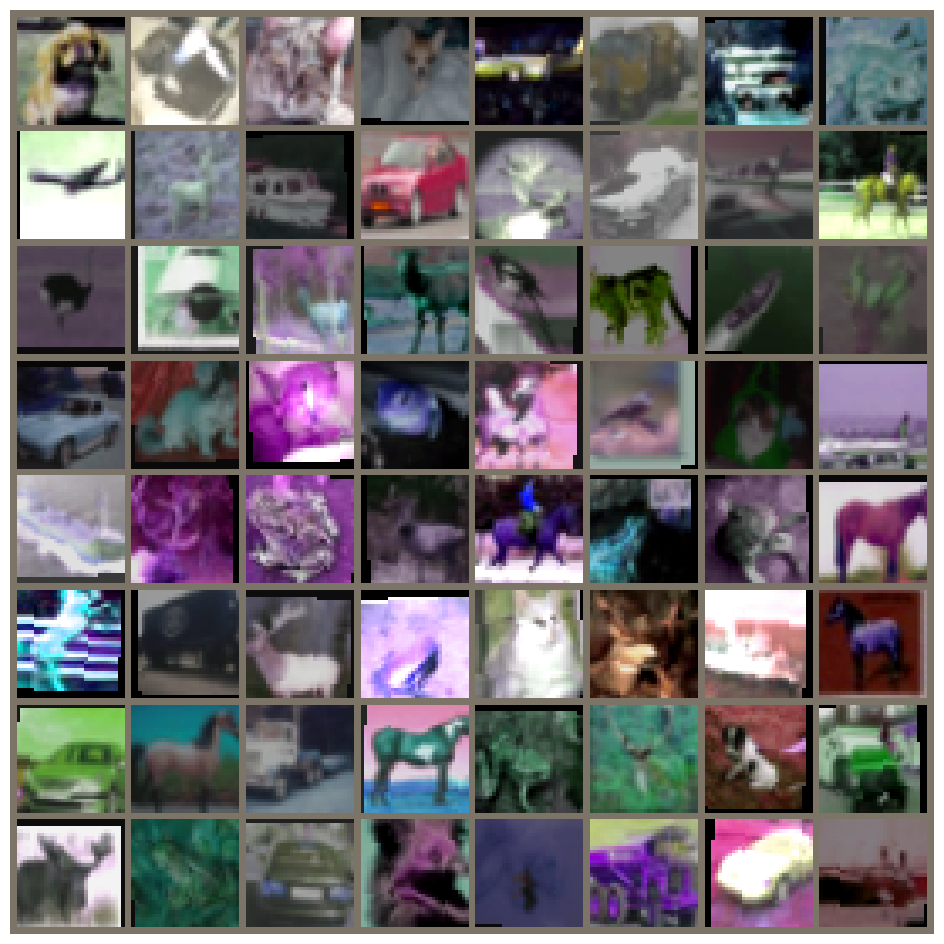

first raw classes   dog   cat   cat   dog airplane truck truck  frog
torch.Size([64, 3, 32, 32])


In [14]:
def imshow(images, mean=mean, std=std):
    img = torchvision.utils.make_grid(images).to(device)
    img = img.transpose(2,0).transpose(0,1)
    img = (img * torch.as_tensor(std).to(device) 
               + torch.as_tensor(mean).to(device) )# unnormalize 
    img = img.data.cpu().numpy()

    plt.figure(figsize=(16,12))
    plt.imshow(img); plt.axis('off'); plt.show()


images, labels = next(iter(trainloader))

imshow(images)

print('first raw classes',' '.join('%5s' % names_classes[labels[j]] for j in range(BATCH_SIZE//8)))

print(images.shape)

Проведем инициализацию весовых параметров модели. Напомним, что для слоев с ReLU рекомендуется проводить инициализацию Кайменга Ге (Kaiming He) с нормальным распределением, а для слоев с сигмоидом инициализацию Хавьера Глора (Xavier Glort) с равномерным распределением. В нашем случа мы воспользуемся функцией `nn.init.kaiming_normal_`. Также проинциализируем смещения нулями для всех слоев.

In [15]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0)
        
model.apply(init_weights);


Для оценки точности работы модели зададим функцию `accuracy`, которая будет подсчитывать число паравильных ответов `correct_cls` и сравнивать с числом ответов всего.

In [16]:
def accuracy(y_pred, y):
    cls_pred = y_pred.argmax(1, keepdim=True)    
    correct_cls = cls_pred.eq(y.view_as(cls_pred)).sum()
    acc = correct_cls.float() / y.shape[0]
    return acc

Теперь зададим параметры обучения. Мы будем использовать `CrossEntropyLoss` в качестве функции потерь и оптимизацию методом `Adam` c переменной скоростью обучения (`LR`). Для организации расписания изменения скорости обучения мы воспользуемся подмодулем `torch.optim.lr_scheduler`. В данном примере мы будем использовать ступенчатый метод изменения скорости `StepLR` с периодом ступени 4 эпохи и коэффициентом изменения скорости 0.9

In [17]:
LR = 0.0004
LR_PERIOD = 4
LR_DECAY  = 0.95 

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

model     = model.to(device)
criterion = criterion.to(device)
metric = accuracy
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size = LR_PERIOD, 
                                            gamma     = LR_DECAY)

Отметим, следующие [практики использования изменяющейся скорости обучения](https://github.com/Devinterview-io/pytorch-interview-questions?tab=readme-ov-file#process-for-implementing-custom-layers):
* __Начните с фиксированной скорости__. Начните обучение с постоянной скорости обучения, чтобы установить базовый уровень и обеспечить начальную сходимость.
* __Настройте параметры планировщика__. Размер шага (`step_size`), гамма (`gamma`) и другие параметры планировщика сильно влияют на производительность модели. Поэкспериментируйте с различными настройками, чтобы найти оптимальный вариант для ваших данных и модели.
* __Следите за потерями и метриками__. Следите за метриками обучения и проверки. Планировщики скорости обучения могут помочь точно настроить модель, адаптируясь к ее изменяющимся потребностям во время обучения.

Когда следует использовать планирование скорости обучения:
* __Разреженные данные__. Для данных с разреженными признаками планирование может помочь модели сосредоточиться на менее распространенных признаках, тем самым повышая производительность.
* __Медленно и быстро обучающиеся признаки__. Не все признаки должны обновляться с одинаковой скоростью. Например, в нейронных сетях весам более ранних слоев может потребоваться больше времени для сходимости. Планирование может помочь ускорить их обновление.
* __Плато потерь__. Когда функция потерь сглаживается, указывая на то, что модель мало чему учится при текущей скорости обучения, планировщик может снизить скорость и вывести модель из колеи.

Перед началом тренировки запишем функцию `train`, которая должна реализовывать тренировку в рамках 1 эпохи. 

Функция будет выбирать все батчи из dataloader в формате `x` - данные и `y` - ответы. Затем для каждого батча будет производится расчет выхода модели `model.forward(x)` и расчет параметров `loss` (потери) и `acc` (точность). 

*Отметим* 
* В режиме тренировки модель должна иметь директиву train  `model.train()`, которая необходима в ряде элементов (например batchnorm), имеющих разное поведения при тренировке и эксплуотации.

* Также отметим, что `dataloader` вызывается при помощи `tqdm` - то есть т.н. *progress bar*.

In [18]:
def train(model, dataloader, optimizer, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x)

        loss = criterion(y_pred, y)
        acc  = metric( y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

Аналогично создадим функцию `evaluate`, которая позволяет оценивать работу модели, например, для валидационного или тестового наборов данных. Особенностями этой функции будут деректива `model.eval()` и `torch.no_grad()`, которые необходимы в режиме тестирования нейронной сети.

In [19]:
def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.inference_mode():
        
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

Запишем вспомогательную функцию расчета времени.

In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Проведем тренировку на 20 эпохах. В ходе проведения тренировки будем контролровать лучшую эпоху проверяя ее loss на валидации. Каждые 2 эпохи будем выводить результат работы сети в текстовом виде.

In [21]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()
    
    train_loss[epoch], train_acc[epoch] = train(model, 
                                                trainloader, 
                                                optimizer, 
                                                criterion, 
                                                metric,
                                                device)
    
    scheduler.step()
    
    valid_loss[epoch], valid_acc[epoch] = evaluate(model, 
                                                   validloader, 
                                                   criterion, 
                                                   metric,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
        f'| Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 48s
	Train Loss: 1.893 | Train Acc: 30.20%
	 Val. Loss: 1.779 |  Val. Acc: 35.05%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 2s
	Train Loss: 1.717 | Train Acc: 37.46%
	 Val. Loss: 1.631 |  Val. Acc: 40.07%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 54s
	Train Loss: 1.624 | Train Acc: 41.25%
	 Val. Loss: 1.513 |  Val. Acc: 44.20%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 54s
	Train Loss: 1.564 | Train Acc: 43.17%
	 Val. Loss: 1.486 |  Val. Acc: 45.09%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 56s
	Train Loss: 1.506 | Train Acc: 45.73%
	 Val. Loss: 1.398 |  Val. Acc: 49.05%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 1m 4s
	Train Loss: 1.473 | Train Acc: 47.02%
	 Val. Loss: 1.384 |  Val. Acc: 49.86%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 1m 4s
	Train Loss: 1.427 | Train Acc: 48.66%
	 Val. Loss: 1.338 |  Val. Acc: 52.27%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 1m 10s
	Train Loss: 1.400 | Train Acc: 49.69%
	 Val. Loss: 1.329 |  Val. Acc: 52.73%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 1m 17s
	Train Loss: 1.369 | Train Acc: 50.70%
	 Val. Loss: 1.314 |  Val. Acc: 52.93%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 1m 14s
	Train Loss: 1.343 | Train Acc: 52.04%
	 Val. Loss: 1.288 |  Val. Acc: 54.29%


Теперь попробуем визуализировать процесс обучения.

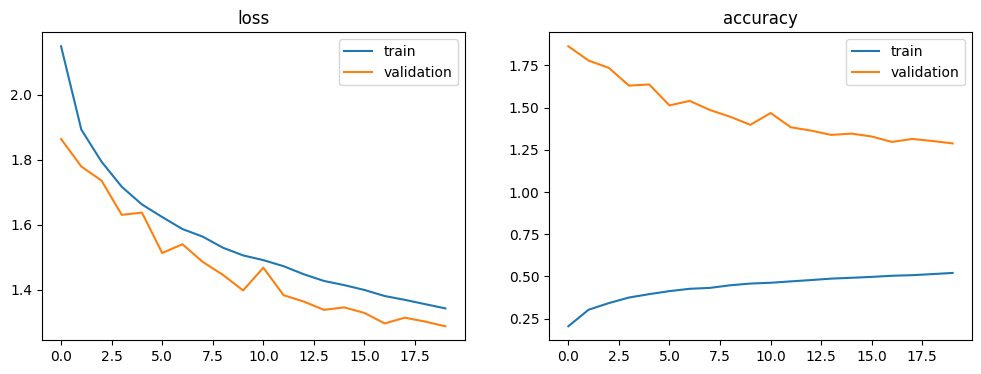

In [22]:
def plot_results(train_loss, valid_loss, train_acc, valid_acc ):
    fig,axs = plt.subplots(1,2,figsize = (12,4))
    axs[0].plot(train_loss.cpu().numpy(), label = 'train')
    axs[0].plot(valid_loss.cpu().numpy(), label = 'validation')
    axs[0].set_title('loss')
    axs[0].legend()
    axs[1].plot(train_acc.cpu().numpy(), label = 'train')
    axs[1].plot(valid_acc.cpu().numpy(), label = 'validation')
    axs[1].set_title('accuracy')
    axs[1].legend()
    plt.show()

plot_results(train_loss, valid_loss, train_acc, valid_loss )


Проверим точность на лучшей эпохе для тестового набора данных.

In [23]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, testloader, criterion, accuracy, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

best epoch 19: Test Loss: 1.310 | Test Acc: 53.92%


Теперь посмотрим на результаты точности по каждому классу  для тестового набора данных. 

Отметим, что в данной операции мы отдельно подсчитываем точность как отношение `class_correct` к `class_total` по каждому классу `label`, а  также собираем  классы для всех экземпляров `labels` и предсказания `predicts`.

In [24]:
model.eval()

n_classes = 10
n_samples = len(testset)

class_correct = torch.zeros(n_classes)
class_total   = torch.zeros(n_classes)

labels   = []
predicts = []

with torch.inference_mode():
    
    for x,y in tqdm(testloader):
        x = x.to(device)
        y = y.to('cpu')

        y_pred = model.forward(x).to('cpu')
        
        cls_pred = torch.argmax(y_pred, dim=1)
        
        c = (cls_pred == y).squeeze() # one-hot vector
        
        for i in range(x.shape[0]):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1
    
        labels.append(y)
        predicts.append(cls_pred)
        
labels   = torch.cat(labels, dim = 0) # make it 1d array
predicts = torch.cat(predicts, dim = 0) # make it 1d array
    
for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' % (
        names_classes[i], 100 * class_correct[i] / class_total[i]))

  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy of airplane : 71 %
Accuracy of automobile : 68 %
Accuracy of  bird : 28 %
Accuracy of   cat : 21 %
Accuracy of  deer : 39 %
Accuracy of   dog : 35 %
Accuracy of  frog : 78 %
Accuracy of horse : 60 %
Accuracy of  ship : 65 %
Accuracy of truck : 69 %


## Задания

__1.__ Добавьте слой __Inception__ к архитектуре, 

__2.__ В ходе работы изучено достаточно много приемов улучшения работы сверточных сетей. Однако, кажется не все нужны и не всегда. Чтобы не углубляться в тонкости необходимости использования тех или иных приемов соли используются с остаточными связми, а также иногда используют операцию `Stochastic Depth` - то есть случайным образом в ходе обучения выключают те или иные слои. То как прием и остаточная связь используются показано ниже

```python
        def __init__(self, ...)
            dropout = 0.5
            layer = ...
            # Drop Path / Stochastic Depth
            self.stochastic_depth = torchvision.ops.StochasticDepth(p=dropout, mode="batch") 

        def forawrd(self,x)
            out = layer(x)
            return x + self.stochastic_depth(out)
````
__Предлагается__ проверить точность ахритектуры при использоавнии остаточной связи и стохастической глубины.

__3.__ Одной из современных альтернатив архитектурам трансформерам является использование т.н. блока `ConvNeXt`. Идея блока предполагает, что если взять свевртку с большим ядром,то можно получить тотже эффект обобщения, что и для слоя трансформер. Для того чтобы создать лучшую способность общать признаки в блоке используется `Depthwise Convolution`, а затем два слоя точечных сверток, первый из которых расширяет число карт признаков, а второй возвращает их число обратно. 

[Одна из реализаций блок](https://github.com/vishhvak/ConvNeXt/blob/master/ConvNeXt.py) приведена ниже.

```python
    class ConvNeXtBlock(torch.nn.Module):
        def __init__(self, in_channels, out_channels, expansion_ratio = 2):
            super().__init__()
            hidden_dim = in_channels * expansion_ratio
            
            # Depthwise Convolution
            self.spatial_mixing = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, in_channels, kernel_size=7, padding=3, groups=in_channels),
                torch.nn.BatchNorm2d(in_channels)
            )
            
            # Pointwise Convolution, Upsampling Channels
            self.feature_mixing = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, hidden_dim, kernel_size=1, stride=1, padding=0),
                torch.nn.GELU(),
            )
            
            # Pointwise convolution, Downsampling Channels
            self.bottleneck = torch.nn.Sequential(
                torch.nn.Conv2d(hidden_dim, out_channels, kernel_size=1, stride=1, padding=0)
        )

        def forward(self, x):
            out = self.spatial_mixing(x)
            out = self.feature_mixing(out)
            out = self.bottleneck(out)

            return x + out
```
__Предлагается__ изучить особенности данного слоя.

__4.__ Часто к стандартным блокам сверточной сети добовляют блоки внимания, одна из самых простых реализаций такого блока, в тоже время одна из лучших реализаций блока - это `Squeeze and excitation block`. [Типичная структура](https://amaarora.github.io/posts/2020-07-24-SeNet.html) блока без использования остаточных связей показана ниже:
<img src="https://amaarora.github.io/images/senet_block.png" with="500px">

```python
    class SE_Block(nn.Module):
    def __init__(self, c, r=16):
        super().__init__()
        self.squeeze_pool = nn.AdaptiveAvgPool2d(1)
        
        self.excitation = nn.Sequential(
            nn.Linear(c, c // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(c // r, c, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        bs, c, _, _ = x.shape
        y = self.squeeze_pool(x).view(bs, c)
        y = self.excitation(y).view(bs, c, 1, 1)
        return x * y.expand_as(x)
```
В ряде случаев (см. например `EfficientNet`) в этом блоке вместо полносвязных слоев используются светочные слои. __Предлагаем__ проверить обе релаизации блока в архитектуре. 

__5.__ Одна из наиболее удачных архитектур сверточных сетей - это `ResNet`. Типичная структура ResNet предполагает:
* входной блок (`steam`), реализуемый слоем с большим ядром и большим шагом, а также слой пулинга.
* 5 Блоки т.н. тела, каждый из блоков состоит из нескольких bottleneck слоев. Внутри блока разменость карты признаков и число каналов сохраняются.
* Глобальный средний пулинг.
* слой принятия решений.
* Если в bottleneck слое происходит сжатие размерности, то слой имеет шаг 2 в основной части и может быть дополнен сверткой $1\times 1$ с нужным шагом в остаточной части.
* Каждая свертка сопровождается батч-нормализацией и функцией активации ReLU.
Иллюстрация приведена ниже, простую реализацию можно найти, например [тут](https://github.com/Lightning-AI/dl-fundamentals/blob/main/unit07-computer-vision/7.4-cnn-training/7.4-part-4-resnet-scratch.ipynb) и [тут](https://d2l.ai/chapter_convolutional-modern/resnet.html)

<img src="https://pytorch.org/assets/images/resnet.png" width="900px">


__Предлагается__ реализовать уменьшенную копию архитектуры `ResNet`, например [`ResNet9`](https://github.com/VanekPetr/ResNet-9/blob/main/model.py)


__6.__ В структуру блоков `ResNet` часто пытаются внести изменения с целью улучшить качество работы архитекутры. Одна из первых попыток такого улучшения - это архитектура `ResNeXt`, иллюстрация которой приведена ниже.

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-06_at_4.32.52_PM.png" width="700px"> 

__Предлагается__ модифицировать описанную архитектуру `ResNet` в соотвествии с идеей `ResNeXt`.